# Importing the Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import shutil
from sklearn.datasets import load_files

#Import required packages
# import numpy as np
import cv2
import random
# import os
import sys
# import shutil
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import configparser
import secrets

from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from keras.preprocessing import image                  
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from PIL import ImageFile               

In [2]:
!ls

'Dance Recognition.ipynb'   dataset   LICENSE   README.md


# Data Augmentation

* As the dataset size is very less we need to augment the data 

In [3]:
DATA_AUG = os.path.join(os.getcwd(),"prepare_augmented_data")

if not os.path.exists(DATA_AUG):
    os.makedirs(DATA_AUG)
    


In [4]:
data_train = pd.read_csv(os.path.join("./dataset/","train.csv"))
data_test = pd.read_csv(os.path.join("./dataset","test.csv"))

data_train['Image'] = data_train['Image'].apply(lambda x:os.path.join(os.getcwd(),"dataset","train",x))
data_test['Image'] = data_test['Image'].apply(lambda x:os.path.join(os.getcwd(),"dataset","test",x))

print("The number of training images is ",data_train.shape[0])
print("The number of testing images is ",data_test.shape[0])

The number of training images is  364
The number of testing images is  156


In [5]:
data_train['target'].value_counts().index

dance_dist = list()
for idx,num_files in enumerate(data_train['target'].value_counts()):
    dance_dist.append({
        "DanceName":data_train['target'].value_counts().index[idx],
        "NumFiles":num_files
    })
dance_dist = pd.DataFrame(dance_dist)


dance_dist.head(10) # shows the classwise distribution of data

,DanceName,NumFiles
0,mohiniyattam,50
1,odissi,49
2,kathakali,47
3,bharatanatyam,47
4,kuchipudi,46
5,sattriya,45
6,kathak,44
7,manipuri,36


In [6]:
data_train.head(10) #creates a csv having file location and class name 

,Image,target
0,/home/abhinav/hackerearth/Dance-Recognition/da...,manipuri
1,/home/abhinav/hackerearth/Dance-Recognition/da...,bharatanatyam
2,/home/abhinav/hackerearth/Dance-Recognition/da...,odissi
3,/home/abhinav/hackerearth/Dance-Recognition/da...,kathakali
4,/home/abhinav/hackerearth/Dance-Recognition/da...,odissi
5,/home/abhinav/hackerearth/Dance-Recognition/da...,kathak
6,/home/abhinav/hackerearth/Dance-Recognition/da...,sattriya
7,/home/abhinav/hackerearth/Dance-Recognition/da...,kuchipudi
8,/home/abhinav/hackerearth/Dance-Recognition/da...,sattriya
9,/home/abhinav/hackerearth/Dance-Recognition/da...,kuchipudi


In [7]:
# putting images belonging to different classes into different folders with corresponding classname
# Preparing dataset for augmentation
for i in range(data_train.shape[0]):
    if not os.path.exists(os.path.join(DATA_AUG,data_train.iloc[i,1])):
        os.makedirs(os.path.join(DATA_AUG,data_train.iloc[i,1]))
    shutil.copy(data_train.iloc[i,0],os.path.join(DATA_AUG,data_train.iloc[i,1],data_train.iloc[i,0].split("/")[-1]))


In [8]:
# Setting the data augmentation definition

gen_per_image = 4
gen_per_class = 300
#path to the folder containing the data ready for augmentation
path = DATA_AUG
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"


In [9]:
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w

    full_sheet = np.ones((new_h, new_w, 3)) * 255

    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])

    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img

    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)

    return full_sheet.astype(np.uint8)

def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img

def copy_org(doc_type):
    files = os.listdir(os.path.join(path, doc_type))

    for file in files:
        shutil.copy(os.path.join(path, doc_type, file), os.path.join(os.getcwd(),"augmented_data",doc_type, file))


#Initialise the parameters for Augmentation.
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        preprocessing_function = preprocess_img)

def generator(doc_type, total):
    # print(doc_type + " " + set_type)
    print(doc_type)
    # src_path = os.path.join(path, doc_type, set_type)
    src_path = os.path.join(path,doc_type)
    dst_path = os.path.join(os.getcwd(), "augmented_data",doc_type)
    # files = os.listdir(src_path)
    files = os.listdir(src_path)
    m = len(files)

    for i in range(total):
        k = secrets.randbelow(m)
        img_cv = cv2.resize(cv2.imread(os.path.join(src_path, files[k])), (500, 500), interpolation = cv2.INTER_AREA)
        cv2.imwrite("temp_img.jpg", img_cv)
        img = load_img("temp_img.jpg")  # this is a PIL image
        # img = load_img(os.path.join(src_path, files[k]))  # this is a PIL image
        imgarr = img_to_array(img)  # this is a Numpy array with shape (?, ?, ?)

        gen_file_name = doc_type + "_" + str(i)

        # cv2.imwrite(os.path.join(dst_path, gen_file_name + ".jpg"), cv2.imread(os.path.join(src_path, files[k])))

        imgarr = imgarr.reshape((1,) + imgarr.shape)  # this is a Numpy array with shape (1, ?, ?, ?)

        n = 1
        for batch in datagen.flow(imgarr, batch_size=1, save_to_dir=dst_path, save_prefix=gen_file_name, save_format='jpeg'):
            n += 1
            if n > gen_per_image:
                break  # otherwise the generator would loop indefinitely



In [10]:

#Contains all the labels
doc_types = os.listdir(path)

for doc_type in doc_types:
    if not os.path.exists(os.path.join(os.getcwd(), "augmented_data",doc_type)):
        os.makedirs(os.path.join(os.getcwd(),"augmented_data",doc_type))
    # generator(doc_type, set_types[0], gen_per_class)
    generator(doc_type,gen_per_class)
    copy_org(doc_type)

manipuri
kuchipudi
kathakali
sattriya
mohiniyattam
odissi
kathak
bharatanatyam


# Data Preparation

In [11]:
# creating the new train.csv
DATA_DIR = os.path.join(os.getcwd(), "augmented_data")
def create_csv(DATA_DIR,filename):
    data = list()
    class_names = os.listdir(DATA_DIR)
    for class_name in class_names:
        file_names = os.listdir(os.path.join(DATA_DIR,class_name))
        for file_name in file_names:
            data.append({
                "FileName":os.path.join(DATA_DIR,class_name,file_name),
                "ClassName":class_name
            })
    data = pd.DataFrame(data)
    data.to_csv(filename,index=False)

create_csv(DATA_DIR,"train_augmented.csv")


data = pd.read_csv(os.path.join(os.getcwd(),"train_augmented.csv"))
# data.head()

In [12]:
TEST_DIR = os.path.join(os.getcwd(),"dataset","test")
TRAIN_DIR = os.path.join(os.getcwd(),"augmented_data")
MODEL_PATH = os.path.join(os.getcwd(),"model")

In [13]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
    

Model path does not exists
Model path created


In [14]:
data_train = pd.read_csv(os.path.join(os.getcwd(),"train_augmented.csv"))
data_test = pd.read_csv(os.path.join("./dataset/","test.csv"))

In [15]:
print("The number of training images is ",data_train.shape[0])
print("The number of testing images is ",data_test.shape[0]) # for submission

The number of training images is  9962
The number of testing images is  156


In [16]:
data_train['FileName'] = data_train['FileName'].apply(lambda x:os.path.join(TRAIN_DIR,"/".join(x.split("/")[-2:])))
data_test['Image'] = data_test['Image'].apply(lambda x:os.path.join(os.getcwd(),"dataset","test",x))

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9962 entries, 0 to 9961
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FileName   9962 non-null   object
 1   ClassName  9962 non-null   object
dtypes: object(2)
memory usage: 155.8+ KB


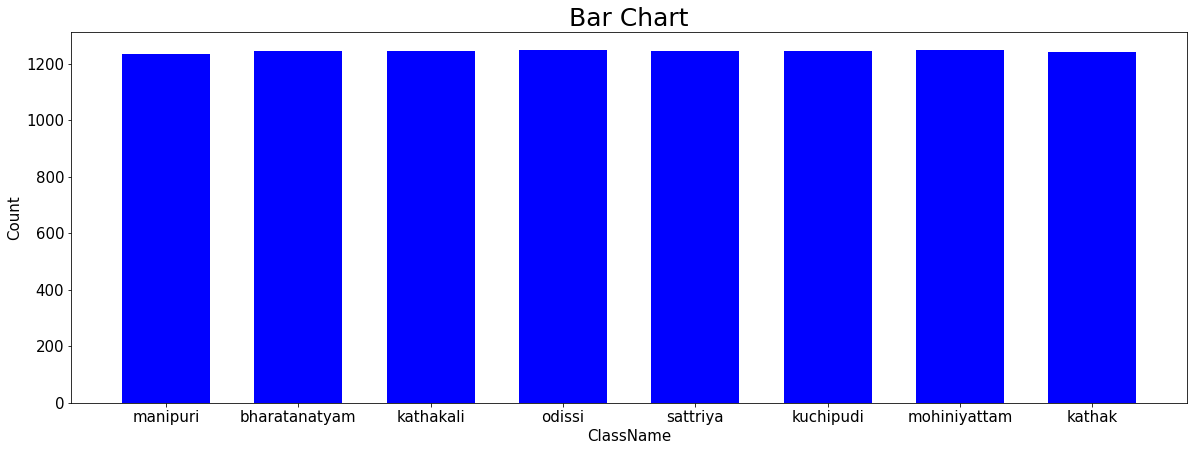

In [18]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('ClassName',size=15)
plt.ylabel('Count',size=15)

plt.show()

1. The classes are well separated and equally balanced into 8 classes

In [19]:
#preparing the dictionary for labels encoding 

labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'sattriya': 0, 'mohiniyattam': 1, 'kathakali': 2, 'bharatanatyam': 3, 'kuchipudi': 4, 'odissi': 5, 'manipuri': 6, 'kathak': 7}


In [20]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(9962, 8)


In [21]:
#splitting data into train and test set in 80:20 ratio

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Data Preprocessing

In [22]:
           
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5
test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5

100%|██████████| 156/156 [00:01<00:00, 137.93it/s]


# Model Architecture

In [23]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         5

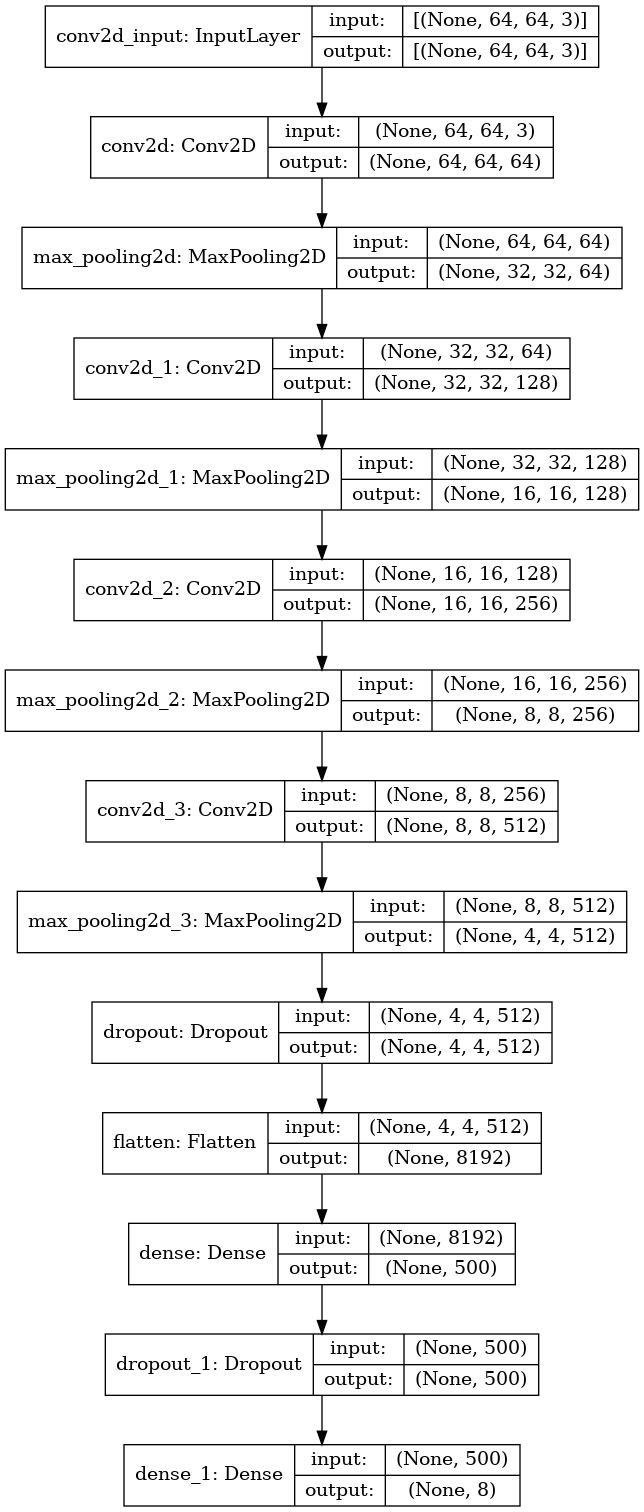

In [24]:
plot_model(model,to_file="model_dance_recognition.png",show_shapes=True,show_layer_names=True)

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
filepath = os.path.join(MODEL_PATH,"dance_recognition-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

# Model Training

In [27]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=10, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/10
200/200 [==============================] - 108s 533ms/step - loss: 1.8393 - accuracy: 0.3108 - val_loss: 0.4896 - val_accuracy: 0.8460

Epoch 00001: val_accuracy improved from -inf to 0.84596, saving model to /home/abhinav/hackerearth/Dance-Recognition/model/dance_recognition-01-0.85.hdf5
Epoch 2/10
200/200 [==============================] - 104s 521ms/step - loss: 0.3424 - accuracy: 0.8859 - val_loss: 0.0463 - val_accuracy: 0.9860

Epoch 00002: val_accuracy improved from 0.84596 to 0.98595, saving model to /home/abhinav/hackerearth/Dance-Recognition/model/dance_recognition-02-0.99.hdf5
Epoch 3/10
200/200 [==============================] - 101s 507ms/step - loss: 0.1056 - accuracy: 0.9684 - val_loss: 0.0072 - val_accuracy: 0.9990

Epoch 00003: val_accuracy improved from 0.98595 to 0.99900, saving model to /home/abhinav/hackerearth/Dance-Recognition/model/dance_recognition-03-1.00.hdf5
Epoch 4/10
200/200 [==============================] - 98s 492ms/step - loss: 0.0522 - accur

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [28]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [29]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [30]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
print(class_names)

['sattriya', 'mohiniyattam', 'kathakali', 'bharatanatyam', 'kuchipudi', 'odissi', 'manipuri', 'kathak']


In [31]:
ypred = model.predict(valid_tensors,verbose=1)

63/63 [==============================] - 6s 87ms/step


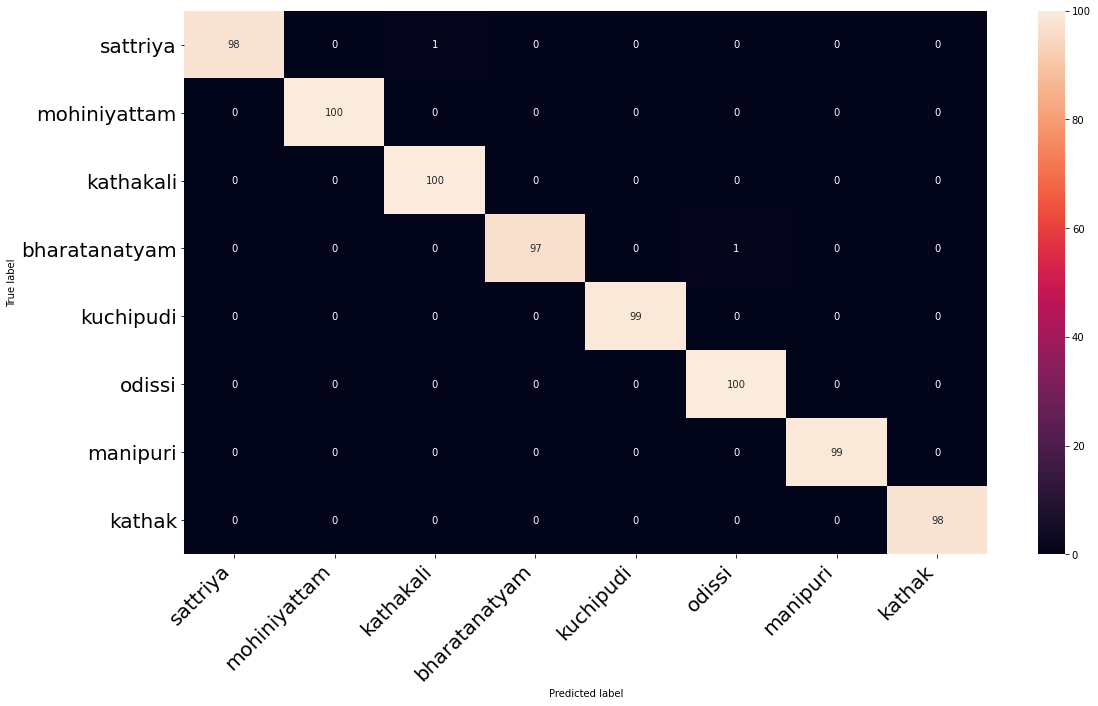

In [32]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [33]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [34]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.992474
Precision: 0.992644
Recall: 0.992474
F1 score: 0.992488


In [35]:
test_pred = model.predict(test_tensors,verbose=1)
test_pred_class = model.predict_classes(test_tensors)
# print(test_pred_class)
# print(test_pred_class.shape)
# print(test_pred_class.shape)

id_labels = dict()
for label,idx in labels_id.items():
    id_labels[idx]=label
# print(id_labels)

5/5 [==============================] - 0s 78ms/step


/home/abhinav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Creating the Submission file

In [36]:
data_submit = list()
for i in range(test_pred_class.shape[0]):
    data_submit.append({
        "Image":data_test.iloc[i,0].split("/")[-1],
        "target":id_labels[test_pred_class[i]]
    })
data_submit = pd.DataFrame(data_submit)
data_submit.to_csv("submission.csv",index=False)